In [1]:
import cppchess as chess
from mcts.c import run_mcts
import tensorflow as tf
from game import Game
from config import Config
import numpy as np

2024-03-11 09:18:08.291633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Testing bot vs random move

In [2]:
#model_name = "r6c64Ad1e-4L2b64"
model_name = "test"
model_path = f"models/{model_name}/saved_model"
model = tf.saved_model.load(model_path)
trt_func = model.signatures["serving_default"]

2024-02-27 10:59:15.432708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5823 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


In [3]:
NUM_GAMES = 1
BOT_COLOR = chess.WHITE
ALTERNATE_COLORS = True
config = Config()
results = {
    model_name: 0,
    "Opponent": 0,
}
for _ in range(NUM_GAMES):
    board = chess.Board()
    game = Game(board)
    while not game.terminal_with_outcome():
        if game.to_play() == BOT_COLOR:
            move, _ = run_mcts(
                game=game,
                config=config,
                network=trt_func,
                root=None,
                reuse_tree=False,
                num_simulations=config.num_mcts_sims,
                num_sampling_moves=0,
                add_noise=False,
                pb_c_factor=1.5,
            )
        else:
            move = np.random.default_rng().choice(game.legal_moves())
        game.make_move(move)
    print(game.outcome_str)
    if game.terminal_value(BOT_COLOR) == 1:
        results[model_name] += 1
    elif game.terminal_value(BOT_COLOR) == -1:
        results["Opponent"] += 1
    else:
        results[model_name] += 0.5
        results["Opponent"] += 0.5
    if ALTERNATE_COLORS:
        BOT_COLOR = not BOT_COLOR
print(results)

2024-02-27 10:59:22.443594: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2024-02-27 10:59:22.443661: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2024-02-27 10:59:27.897508: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1329] [TF-TRT] Sparse compute capability: enabled.


White wins: outcome=Checkmate
{'test': 1, 'Opponent': 0}


## Testing Bot vs Other bot

In [1]:
import cppchess as chess
from mcts.c import run_mcts
from game import Game
from config import Config

model1_name = "r4c48Ad1e-5L2b64"
#model2_name = "r4c48Ad1e-4L2b64"
model2_name = "test"

2024-03-01 12:08:11.411458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from multiprocessing import Manager, Process

def play_game(name, color, num_games, alternate_colors, history, results, barrier):
    import tensorflow as tf
    gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

    model_path = f"models/{name}/saved_model"
    model = tf.saved_model.load(model_path)
    trt_func = model.signatures["serving_default"]
    
    for i in range(num_games):
        config = Config()
        board = chess.Board()
        game = Game(board)
        while not game.terminal_with_outcome():
            if game.to_play() == color:
                move, _ = run_mcts(
                    game=game,
                    config=config,
                    network=trt_func,
                    root=None,
                    reuse_tree=False,
                    num_simulations= 600, #config.num_mcts_sims,
                    num_sampling_moves=config.num_mcts_sampling_moves,
                    add_noise=config.add_dirichlet_noise,
                    pb_c_factor=config.pb_c_factor,
                )
                history[i].append(move)
            barrier.wait()
            game.make_move(history[i][-1])

        if game.terminal_value(color) == 1:
            results[name] += 1
        elif game.terminal_value(color) != -1:
            results[name] += 0.5
        if alternate_colors:
            color = not color

if __name__ == "__main__":
    NUM_GAMES = 20
    ALTERNATE_COLORS = True
    with Manager() as manager:
        barrier = manager.Barrier(2)
        history = manager.list()
        for _ in range(NUM_GAMES):
            history.append(manager.list())
        results = manager.dict({
            model1_name: 0,
            model2_name: 0,
        })
        p1 = Process(target=play_game, args=(model1_name, chess.WHITE, NUM_GAMES, ALTERNATE_COLORS, history, results, barrier))
        p2 = Process(target=play_game, args=(model2_name, chess.BLACK, NUM_GAMES, ALTERNATE_COLORS, history, results, barrier))
        p1.start()
        p2.start()
        p1.join()
        p2.join()
        print(results)


2024-03-01 08:49:54.075402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5959 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-01 08:49:54.075407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5959 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-01 08:49:56.915209: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2024-03-01 08:49:56.923441: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2024-03-01 08:50:02.602346: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1329] [TF-TRT] Sparse compute capability: enabled.
2024-03-01 08:50:32.789663: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT

{'r4c48Ad1e-5L2b64': 12.5, 'test': 7.5}


## Playing vs bot

In [1]:
import chess
from game import Game
from mcts import run_mcts
from config import Config
from trt_funcs import load_trt_model_latest

player = chess.WHITE
trt_func, model = load_trt_model_latest()

config = Config()
game = Game(chess.Board())
root = None

2024-03-27 08:16:04.241109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 08:16:05.804561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5630 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-27 08:16:07.280510: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


Time for MCTS: 15.02s
Visits: 14775
Summed value: 8315.334386
Evaluation: 0.565466
Best variation: h8g8 -> g7h8 -> g8h8 -> e1d2 -> d8e8 -> d2e3
Move          Visits  NN Output                    Policy             Prior          Avg. value     UCB            Q+U           
----------------------------------------------------------------------------------------------------------------------------------
h8g8  (None)  N: 2489  (v: 0.491120, p:  12.825769)  (p_norm:  14.57%)  (P: 0.145673)  (Q: 0.444218)  (U: 0.486575)  (Q+U: 0.930793)
c7c5  (None)  N: 1736  (v: 0.494682, p:  11.466936)  (p_norm:   4.35%)  (P: 0.043533)  (Q: 0.469506)  (U: 0.486473)  (Q+U: 0.955979)
d8e8  (None)  N: 1701  (v: 0.491437, p:  12.399006)  (p_norm:   9.97%)  (P: 0.099685)  (Q: 0.444210)  (U: 0.486600)  (Q+U: 0.930810)
d7d6  (None)  N: 1407  (v: 0.488459, p:  12.088849)  (p_norm:   7.57%)  (P: 0.075666)  (Q: 0.447652)  (U: 0.486965)  (Q+U: 0.934617)
h5h4  (None)  N: 1172  (v: 0.490184, p:  12.271691)  (p_norm:  

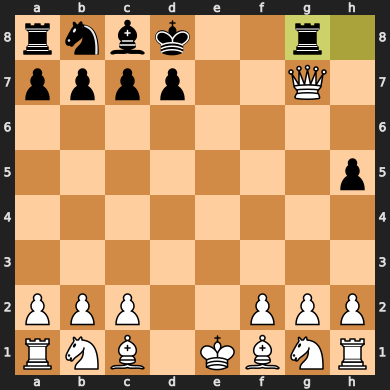

In [21]:
if game.to_play() == player:
    move = input("Enter move: ")
    game.make_move(move)
else:
    move, root, visit_counts = run_mcts(
        game,
        config,
        trt_func, 
        num_simulations=config.num_mcts_sims, 
        time_limit=config.time_limit,
        root=root,
        verbose_move=True, 
        engine_play=True)
    game.make_move(move)
if root:
    root = root[move]

game.board

In [24]:
root["c1g5"]["d8e8"].display_move_statistics()

Visits: 20
Summed value: 8.790492
Evaluation: 0.510446
Move          Visits  NN Output                    Policy             Prior          Avg. value     UCB            Q+U           
----------------------------------------------------------------------------------------------------------------------------------
g7h8  (None)  N: 3    (v: 0.610139, p:  12.128406)  (p_norm:   7.75%)  (P: 0.077525)  (Q: 0.535909)  (U: 0.958487)  (Q+U: 1.494396)
g1f3  (None)  N: 2    (v: 0.619620, p:  11.354085)  (p_norm:   3.90%)  (P: 0.038952)  (Q: 0.558891)  (U: 0.841983)  (Q+U: 1.400874)
b1a3  (None)  N: 2    (v: 0.612865, p:  11.914529)  (p_norm:   6.41%)  (P: 0.064103)  (Q: 0.554572)  (U: 1.020460)  (Q+U: 1.575032)
h2h3  (None)  N: 2    (v: 0.597034, p:  11.425033)  (p_norm:   4.15%)  (P: 0.041487)  (Q: 0.559776)  (U: 0.861297)  (Q+U: 1.421073)
a2a3  (None)  N: 2    (v: 0.603992, p:  11.732293)  (p_norm:   5.45%)  (P: 0.054517)  (Q: 0.558720)  (U: 0.954936)  (Q+U: 1.513656)
f2f4  (None)  N: 2    (v